<a href="https://colab.research.google.com/github/ilanb1/DSP-IP/blob/main/face_swapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

load celebA dataset

In [ ]:
!pip3 install "hub[all]" 
import hub

In [2]:
#downloading only the test set (which is also already too big)
ds = hub.load("hub://activeloop/celeb-a-test")

hub://activeloop/celeb-a-test loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/celeb-a-test


In [3]:
print(f" number of images: {len(ds)}")

 number of images: 19962


In [4]:
#using only the first 300 images:
images_list = ds.images[:300].numpy(aslist=True)

In [5]:
import matplotlib.pyplot as plt
import cv2
import random

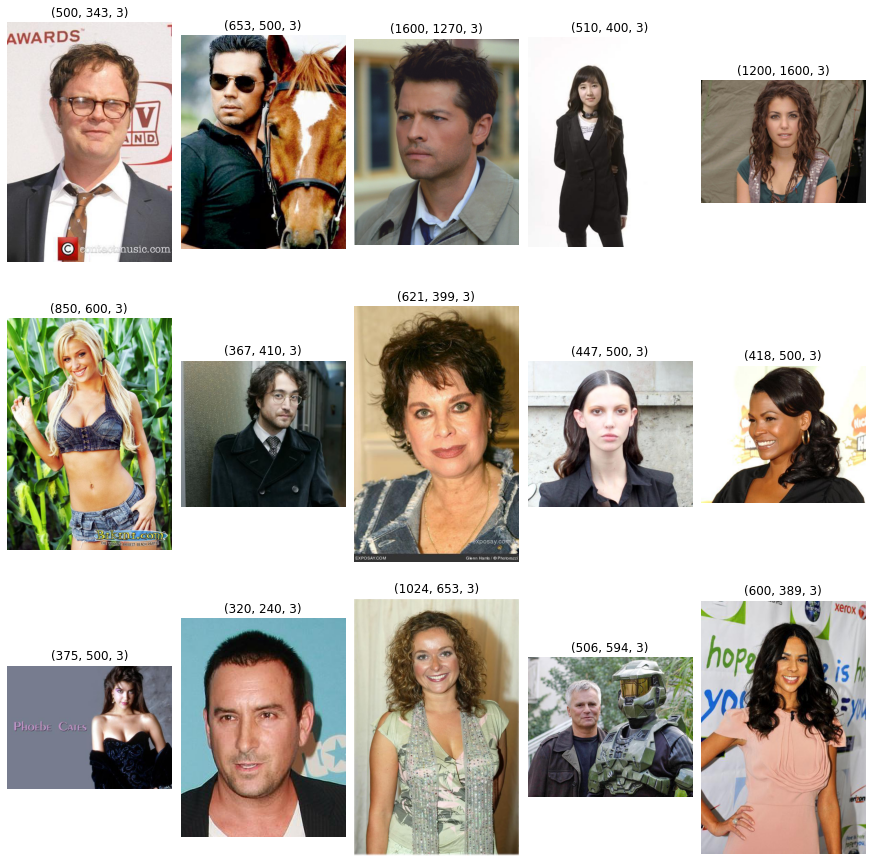

In [9]:
#exploring the images:

fig, ax = plt.subplots(3, 5,constrained_layout=True, figsize=(12,12))

for index, image in enumerate(images_list[:15]):
  ax[index//5 , index%5].imshow(image)
  ax[index//5 , index%5].set_title(image.shape)
  ax[index//5 , index%5].axis("off")



#**Face swapping** (simple approach)


In [11]:
import dlib
import numpy as np

In [14]:
# getting the predictor for the 68 face landmarks

!wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 # DOWNLOAD LINK

!bunzip2 /content/shape_predictor_68_face_landmarks.dat.bz2

datFile =  "/content/shape_predictor_68_face_landmarks.dat"

--2022-06-18 12:22:05--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  49.4MB/s    in 1.2s    

2022-06-18 12:22:06 (49.4 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [12]:
def get_face(image):
  
  img = image.copy()
  gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
   
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor(datFile)

  faces = detector(gray_image)
  
  #if found more than 1 face, or no faces at all, return False
  if len(faces)!=1:
    return False, _ , _
  
  for face in faces:
    landmarks = predictor(gray_image, face)
    landmarks_points = []
    for n in range(0, 68):
      x = landmarks.part(n).x
      y = landmarks.part(n).y
      landmarks_points.append((x, y))
  
  mask = np.zeros_like(gray_image)
  points = np.array(landmarks_points, np.int32)
  convexhull = cv2.convexHull(points)
  cv2.fillConvexPoly(mask, convexhull, 255)
  face_image = cv2.bitwise_and(img, img, mask=mask)

  rect = cv2.boundingRect(convexhull)
  (x, y, w, h) = rect
  cropped_face = face_image[y: y + h, x: x + w]

  return True, cropped_face, [x, y, w, h]

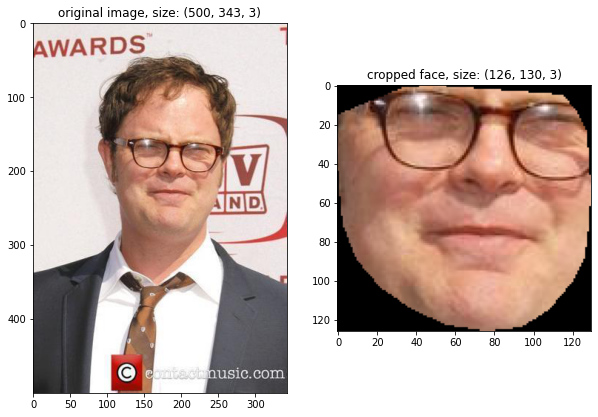

In [18]:
# Testing the above function:

image = images_list[0].copy()

success, face, _ = get_face(image)

if success:
  fig, arr = plt.subplots(1, 2, figsize=(10, 10))
  arr[0].imshow(image)
  arr[0].set_title(f"original image, size: {image.shape}")
  arr[1].imshow(face)
  arr[1].set_title(f"cropped face, size: {face.shape}")

else:
  print("found too many faces, or no faces at all")

In [28]:
def smart_paste(face, region):
  
  ret , mask = cv2.threshold(face,0,255, cv2.THRESH_BINARY_INV)
  final = cv2.bitwise_and(region , mask) + face

  return final

In [35]:
def swap_faces(image1, image2):

  #getting the faces:
  success1, face1, rect1 = get_face(image1)
  success2, face2, rect2 = get_face(image2)

  #if we didnt find exactly 1 face in each image, return False
  if not (success1 and success2):
    return False, _
    
  #getting the positions of the faces:
  [x1, y1, w1, h1] = rect1
  [x2, y2, w2, h2] = rect2

  #resizing the faces so they will match their new position in the other image
  new_face1 = cv2.resize(face2, dsize=(w1, h1), interpolation=cv2.INTER_CUBIC)
  new_face2 = cv2.resize(face1, dsize=(w2, h2), interpolation=cv2.INTER_CUBIC)

  # making copies to not touch the original images:
  img1 = image1.copy()
  img2 = image2.copy()
  
  # pasting the new faces in the images
  img1[y1 : y1+h1 , x1 : x1+ w1 ] = smart_paste(new_face1 , img1[y1 : y1+h1 , x1 : x1+ w1 ] )
  img2[y2 : y2+h2 , x2 : x2+ w2 ] = smart_paste(new_face2 , img2[y2 : y2+h2 , x2 : x2+ w2 ])

  return True, [img1, img2]

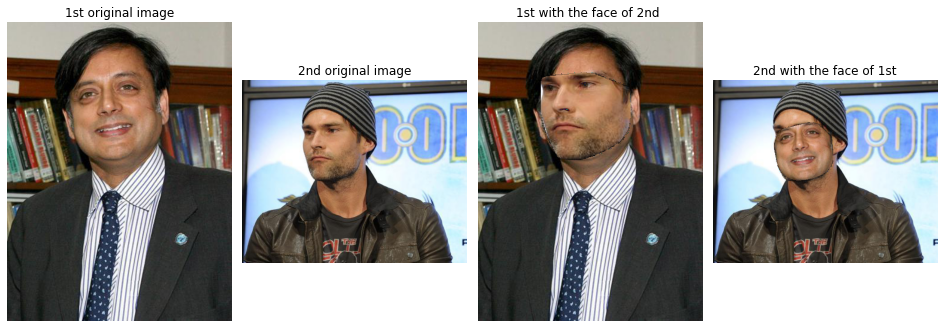

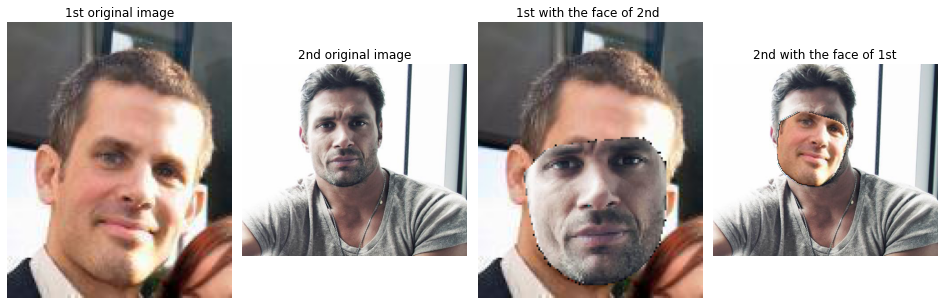

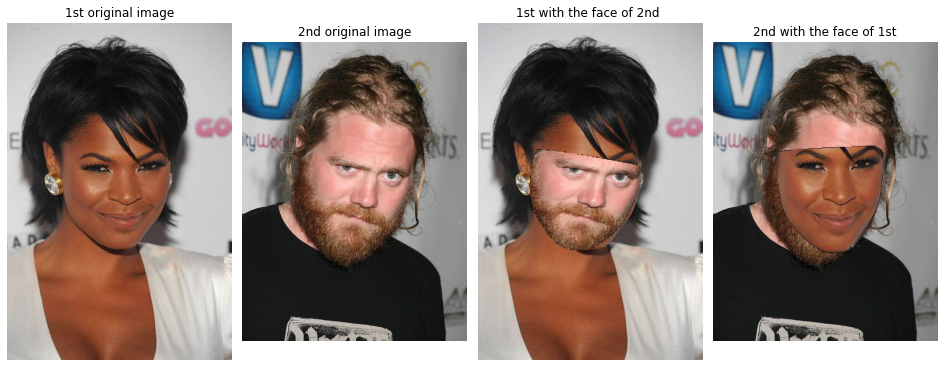

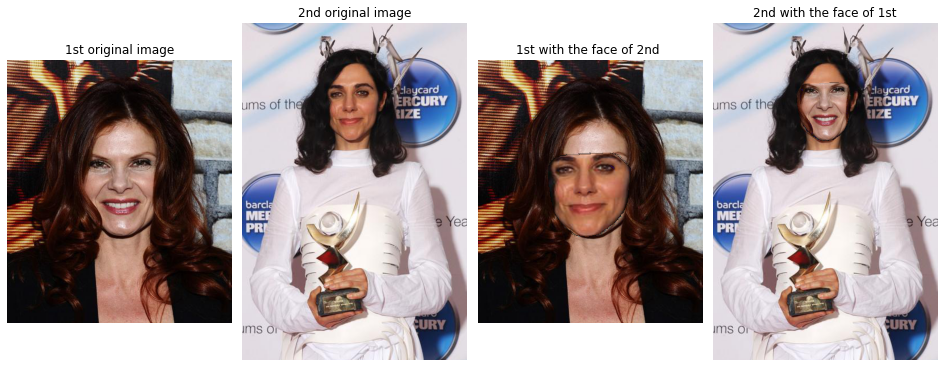

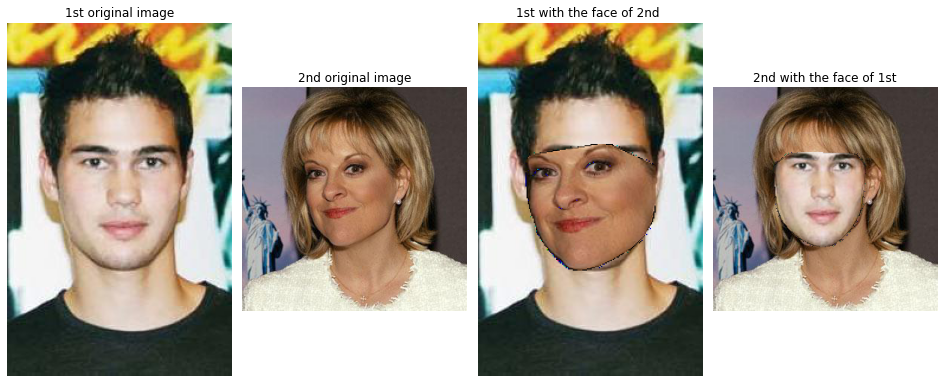

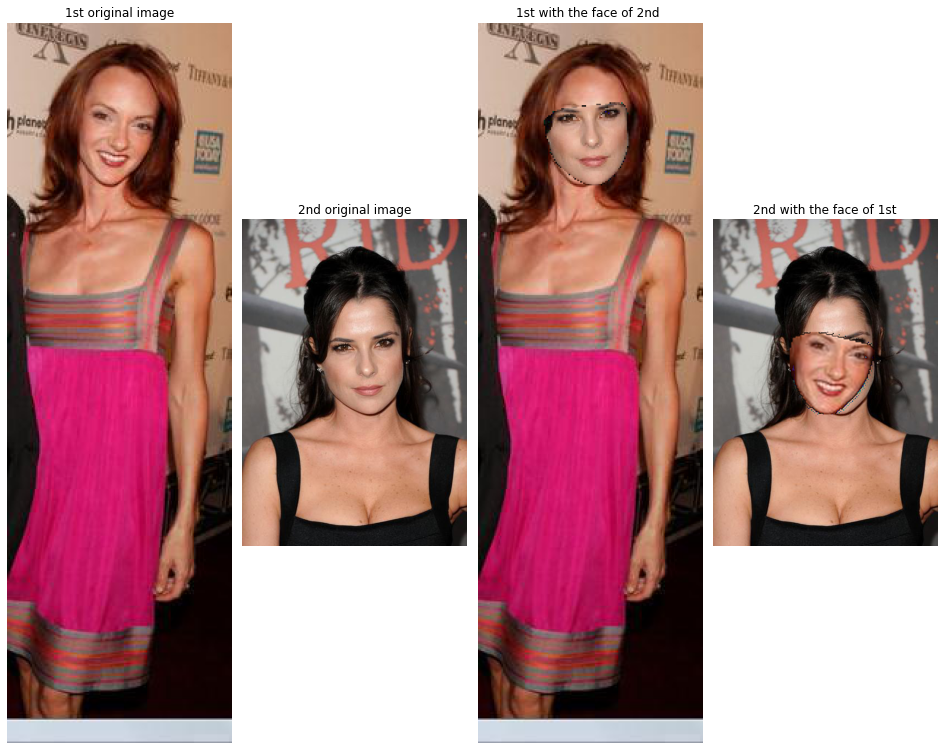

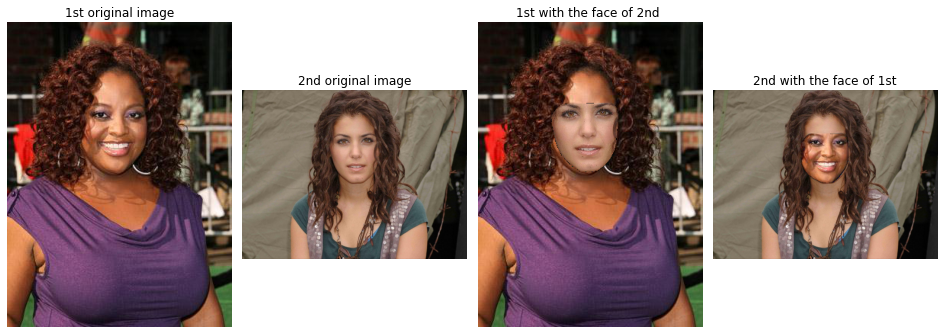

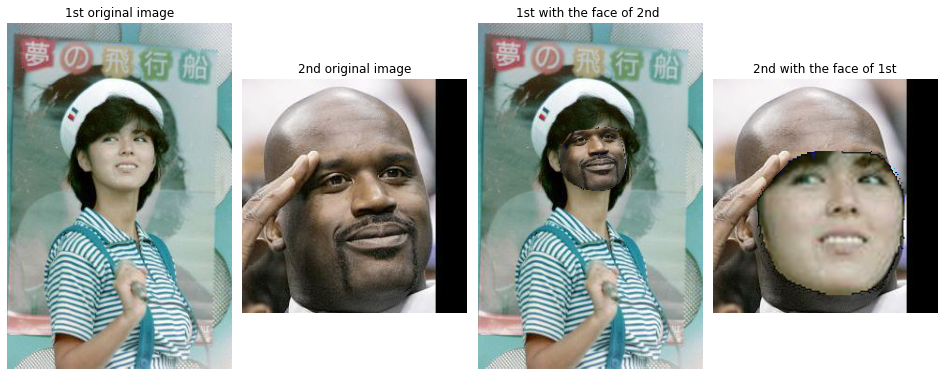

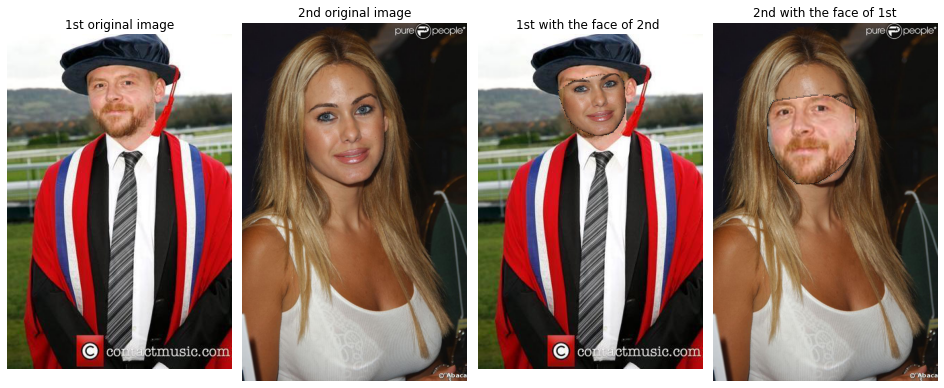

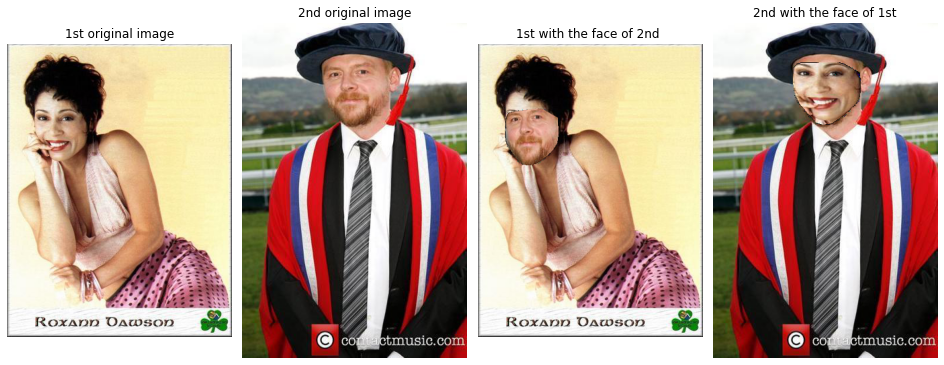

In [40]:
#plot results

counter = 10 #the nubmer of examples we want to see

while counter > 0:
  images = [images_list[random.randint(0,299)], images_list[random.randint(0,299)]]
  success , swapped_images = swap_faces(*images)
  if success:    
    counter-=1
    fig, arr = plt.subplots(1, 4,constrained_layout=True, figsize=(13,13))
    arr[0].imshow(images[0])
    arr[0].set_title("1st original image")
    arr[1].imshow(images[1])
    arr[1].set_title("2nd original image") 
    arr[2].imshow(swapped_images[0])
    arr[2].set_title("1st with the face of 2nd ")
    arr[3].imshow(swapped_images[1])
    arr[3].set_title("2nd with the face of 1st")
    [arr.set_axis_off() for arr in arr.ravel()]
    plt.show()
    
  else:
    #didnt find face in one of the images (or found more than 1 face)
    continue
